In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import math
import glob
import pickle
import statistics
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
import dask
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
out = pickle.load( open( "../HIGH_OUT/latslons_sun.p", "rb" ) )

In [3]:
x = xr.open_mfdataset("/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/6hr/native/zg*")
x = x.rename({'latitude':'lat'})
x = x.rename({'longitude':'lon'})
x = x.rename({'level':'plev'})
x = x.sel(plev=850)
x = x.sel(lat=slice(0,-60))
x = x[['zg']]
x = x.assign_coords(lon=(((x.lon + 180) % 360) - 180))
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    x = x.sortby(x.lon)
x = x.sel(lon=slice(-50,20))
x = x.resample(time="QS-DEC").mean(dim="time",skipna=True)
x = x.load()
x['maxi']=x.zg
for i in range(len(x.time)):
    x.maxi[i] = x.zg[i].where((x.zg[i]==np.max(x.zg[i])))
    

In [21]:
east=[]
south=[]
pres=[]
for i in range(len(x.time)):
    ids =  np.argwhere(~np.isnan(x.maxi[i].values))
    latsid = [item[0] for item in ids]
    lonsid = [item[1] for item in ids]
    east.append(x.lon.values[np.max(lonsid)])
    south.append(x.lat.values[np.max(latsid)])
    pres.append(x.maxi.values[i][np.max(latsid)][np.max(lonsid)])
out=pd.DataFrame(np.array([x.time.values,east,south,pres]).T,columns=['time','east','south','pressure'])
x.close()

In [22]:
bottom = out.south.mean() - 3*(out.south.std())
top = out.south.mean() + 3*(out.south.std())
bottom_e = out.east.mean() - 3*(out.east.std())
top_e = out.east.mean() + 3*(out.east.std())
out = out.where((out.south > bottom) & (out.south<top))
out = out.where((out.east > bottom_e) & (out.east < top_e)).dropna()

In [23]:
out

,time,east,south,pressure
0,281318400000000000,-14.75,-28,1560.38
1,289094400000000000,-9,-26.5,1545.69
2,297043200000000000,-27,-23.25,1560.08
3,304992000000000000,-4.25,-28.25,1546.82
4,312854400000000000,-12.5,-28.5,1555.28
...,...,...,...,...
163,1567296000000000000,-15.25,-24.75,1546.2
164,1575158400000000000,-14.75,-27.75,1559.82
165,1583020800000000000,-4.75,-28,1556.7
166,1590969600000000000,-18,-26,1573.49


In [24]:
out.time = out.time = pd.to_datetime(out.time)
out.east = pd.to_numeric(out.east)
out.south = pd.to_numeric(out.south)
out.pressure=pd.to_numeric(out.pressure)

In [28]:
pr = xr.open_mfdataset('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/1hr/native/pr*')
pr = pr.sel(latitude=-34).sel(longitude=18)
pr = pr.resample(time='QS-DEC').mean(dim='time',skipna=True)

In [29]:
#pr = pr.load()

In [30]:
out['pr'] = pr.where(pr.time.isin(out.time)).pr.dropna(dim='time')

In [31]:
out['pr'] = out.pr*86400

In [32]:
pickle.dump( out, open( "../HIGH_OUT/ERA5_full.p", "wb" ) )

In [33]:
out = pickle.load( open( "../HIGH_OUT/ERA5_full.p", "rb" ) )

In [34]:
seasons =[]
for i in range(len(out.time)):
    if out.iloc[i].time.month == 12:
        seasons.append('Summer')
    elif out.iloc[i].time.month == 3:
        seasons.append('Autumn')
    elif out.iloc[i].time.month == 6:
        seasons.append('Winter')
    else:
        seasons.append('Spring')


out['season'] = seasons

In [35]:
D0 = out.where(out.time.dt.year.isin([2015,2016,2017])).dropna()
D0_winter = D0.where(D0.season=="Winter").dropna().reset_index()
out_winter = out.where(out.season=="Winter").dropna().reset_index()

In [61]:
np.mean(out.pressure)

1556.6019770924638

In [68]:
(D0_winter.pressure - np.mean(out.pressure))

0   -1.613855
1   -1.371057
2    6.710791
Name: pressure, dtype: float64

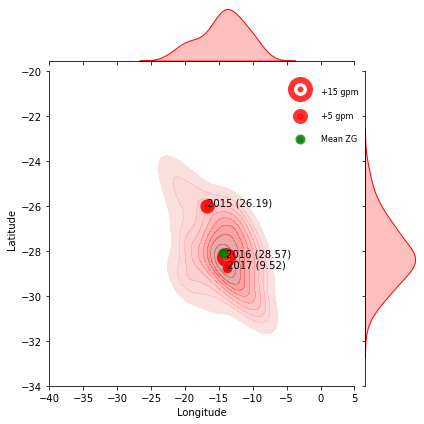

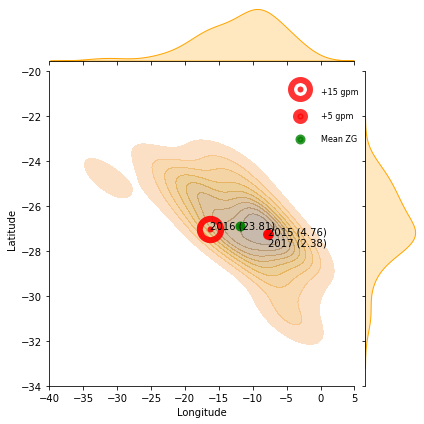

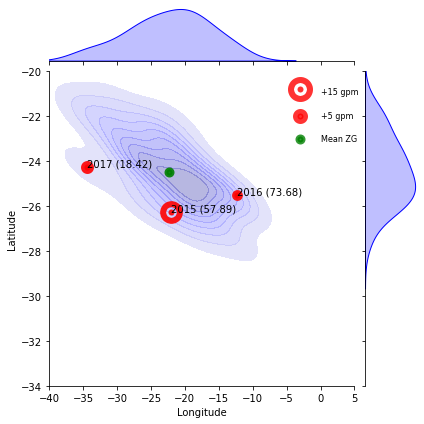

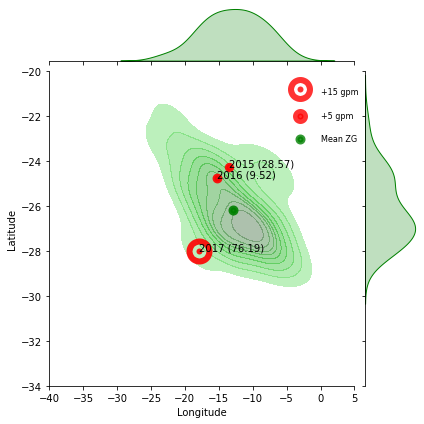

In [116]:
for seas,col in zip(['Summer','Autumn','Winter','Spring'],['r','orange','b','g']):  
    D0_seas = D0.where(D0.season==str(seas)).dropna().reset_index()
    out_seas = out.where(out.season==str(seas)).dropna().reset_index()
    df  = out_seas
    g = sns.jointplot(data= df,x='east',y = 'south',hue='season',kind="kde",fill=True,  palette=[str(col)],joint_kws={'alpha': 0.4},legend=False,xlim=(-40,5),ylim=(-34,-20))
    d = D0_seas
    for i in range(len(d.time)):
        g.ax_joint.scatter(d.east.values[i],d.south.values[i],color = "red",lw=4+((d.pressure.values[i] - np.mean(df.pressure.values))),alpha=0.9)
    g.ax_joint.scatter(np.mean(df.east.values),np.mean(df.south.values),color = "green",lw=4,alpha=0.9)
    #legend
    g.ax_joint.scatter(-3,-20.8,color = "red",lw=4+15,alpha=0.8)
    g.ax_joint.scatter(-3,-22,color = "red",lw=4+5,alpha=0.8)
    g.ax_joint.scatter(-3,-23,color = "green",lw=4,alpha=0.8)
    g.ax_joint.text(0,-21,'+15 gpm',fontsize=8)
    g.ax_joint.text(0,-22.1,'+5 gpm',fontsize=8)
    g.ax_joint.text(0,-23.1,'Mean ZG',fontsize=8)
    temp = []
    for i in range(len(d.time)):
        if d.south.values[i] in temp:
            g.ax_joint.text(d.east.values[i],d.south.values[i]-0.5,str(d.time.dt.year.values[i])+' ('+str(round(stats.percentileofscore(df.pr,d.pr[i]),2))+')')
        else:
            g.ax_joint.text(d.east.values[i],d.south.values[i],str(d.time.dt.year.values[i])+' ('+str(round(stats.percentileofscore(df.pr,d.pr[i]),2))+')')
        temp.append(d.south.values[i])
    g.ax_joint.set_xlabel('Longitude')
    g.ax_joint.set_ylabel('Latitude')
    plt.savefig("../HIGH_OUT/D0_shift/heatmap/ERA5_"+str(seas)+".pdf")
    plt.savefig("../HIGH_OUT/D0_shift/heatmap/ERA5_"+str(seas)+".png",dpi=1000)

In [40]:
for i in range(len(D0_winter)):
    print(D0_winter.time[i])
    print(stats.percentileofscore(out_winter.pr,D0_winter.pr[i]))

2015-09-01 00:00:00
29.26829268292683
2016-09-01 00:00:00
9.75609756097561
2017-09-01 00:00:00
78.04878048780488


In [43]:
seas="Winter"
D0_winter = D0.where(D0.season==str(seas)).dropna().reset_index()
out_winter = out.where(out.season==str(seas)).dropna().reset_index()
for i in range(len(D0_winter)):
    print(D0_winter.time[i])
    print(stats.percentileofscore(out_winter.pr,D0_winter.pr[i]))

2015-06-01 00:00:00
56.75675675675676
2016-06-01 00:00:00
72.97297297297297
2017-06-01 00:00:00
18.91891891891892
